In [129]:
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from matplotlib.patches import Ellipse

sep.set_sub_object_limit(5000)

In [141]:
def img_flux_to_ab_mag(flux: float, zero_point: float) -> float:
    return -2.5 * np.log10(flux) + zero_point

In [137]:
hdul = fits.open('Data/random_sky_images/test0.fits')
image_data = hdul[0].data
image_data = image_data.byteswap().newbyteorder()
hdul[0].header

SIMPLE  =                    T / This is a FITS file                            
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  601 / NUMBER OF ELEMENTS ALONG THIS AXIS             
NAXIS2  =                  601 / NUMBER OF ELEMENTS ALONG THIS AXIS             
BUNIT   = 'DN'                 / units of pixel values                          
EXTEND  =                    T / This file may contain FITS extensions          
EQUINOX =   2.000000000000E+03 / Mean equinox                                   
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CRVAL1  =   2.788585204000E+02 / World coordinate on this axis                  
CRPIX1  = 2.735000000000000E+02 / Reference pixel on this axis                  
CD1_1   =   2.777764318638E-

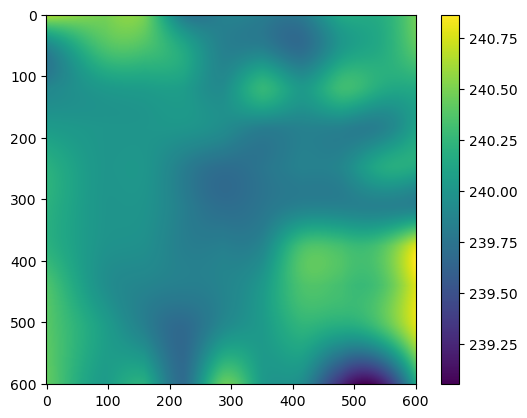

In [138]:
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)
bkg_image = bkg.back()
plt.imshow(np.flipud(bkg_image))
plt.colorbar()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_7464/3734521923.py:2: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + zero_point


Data/random_sky_images/coordinates_thresh1.txt
Data/random_sky_images/coordinates_thresh2.txt
Data/random_sky_images/coordinates_thresh3.txt


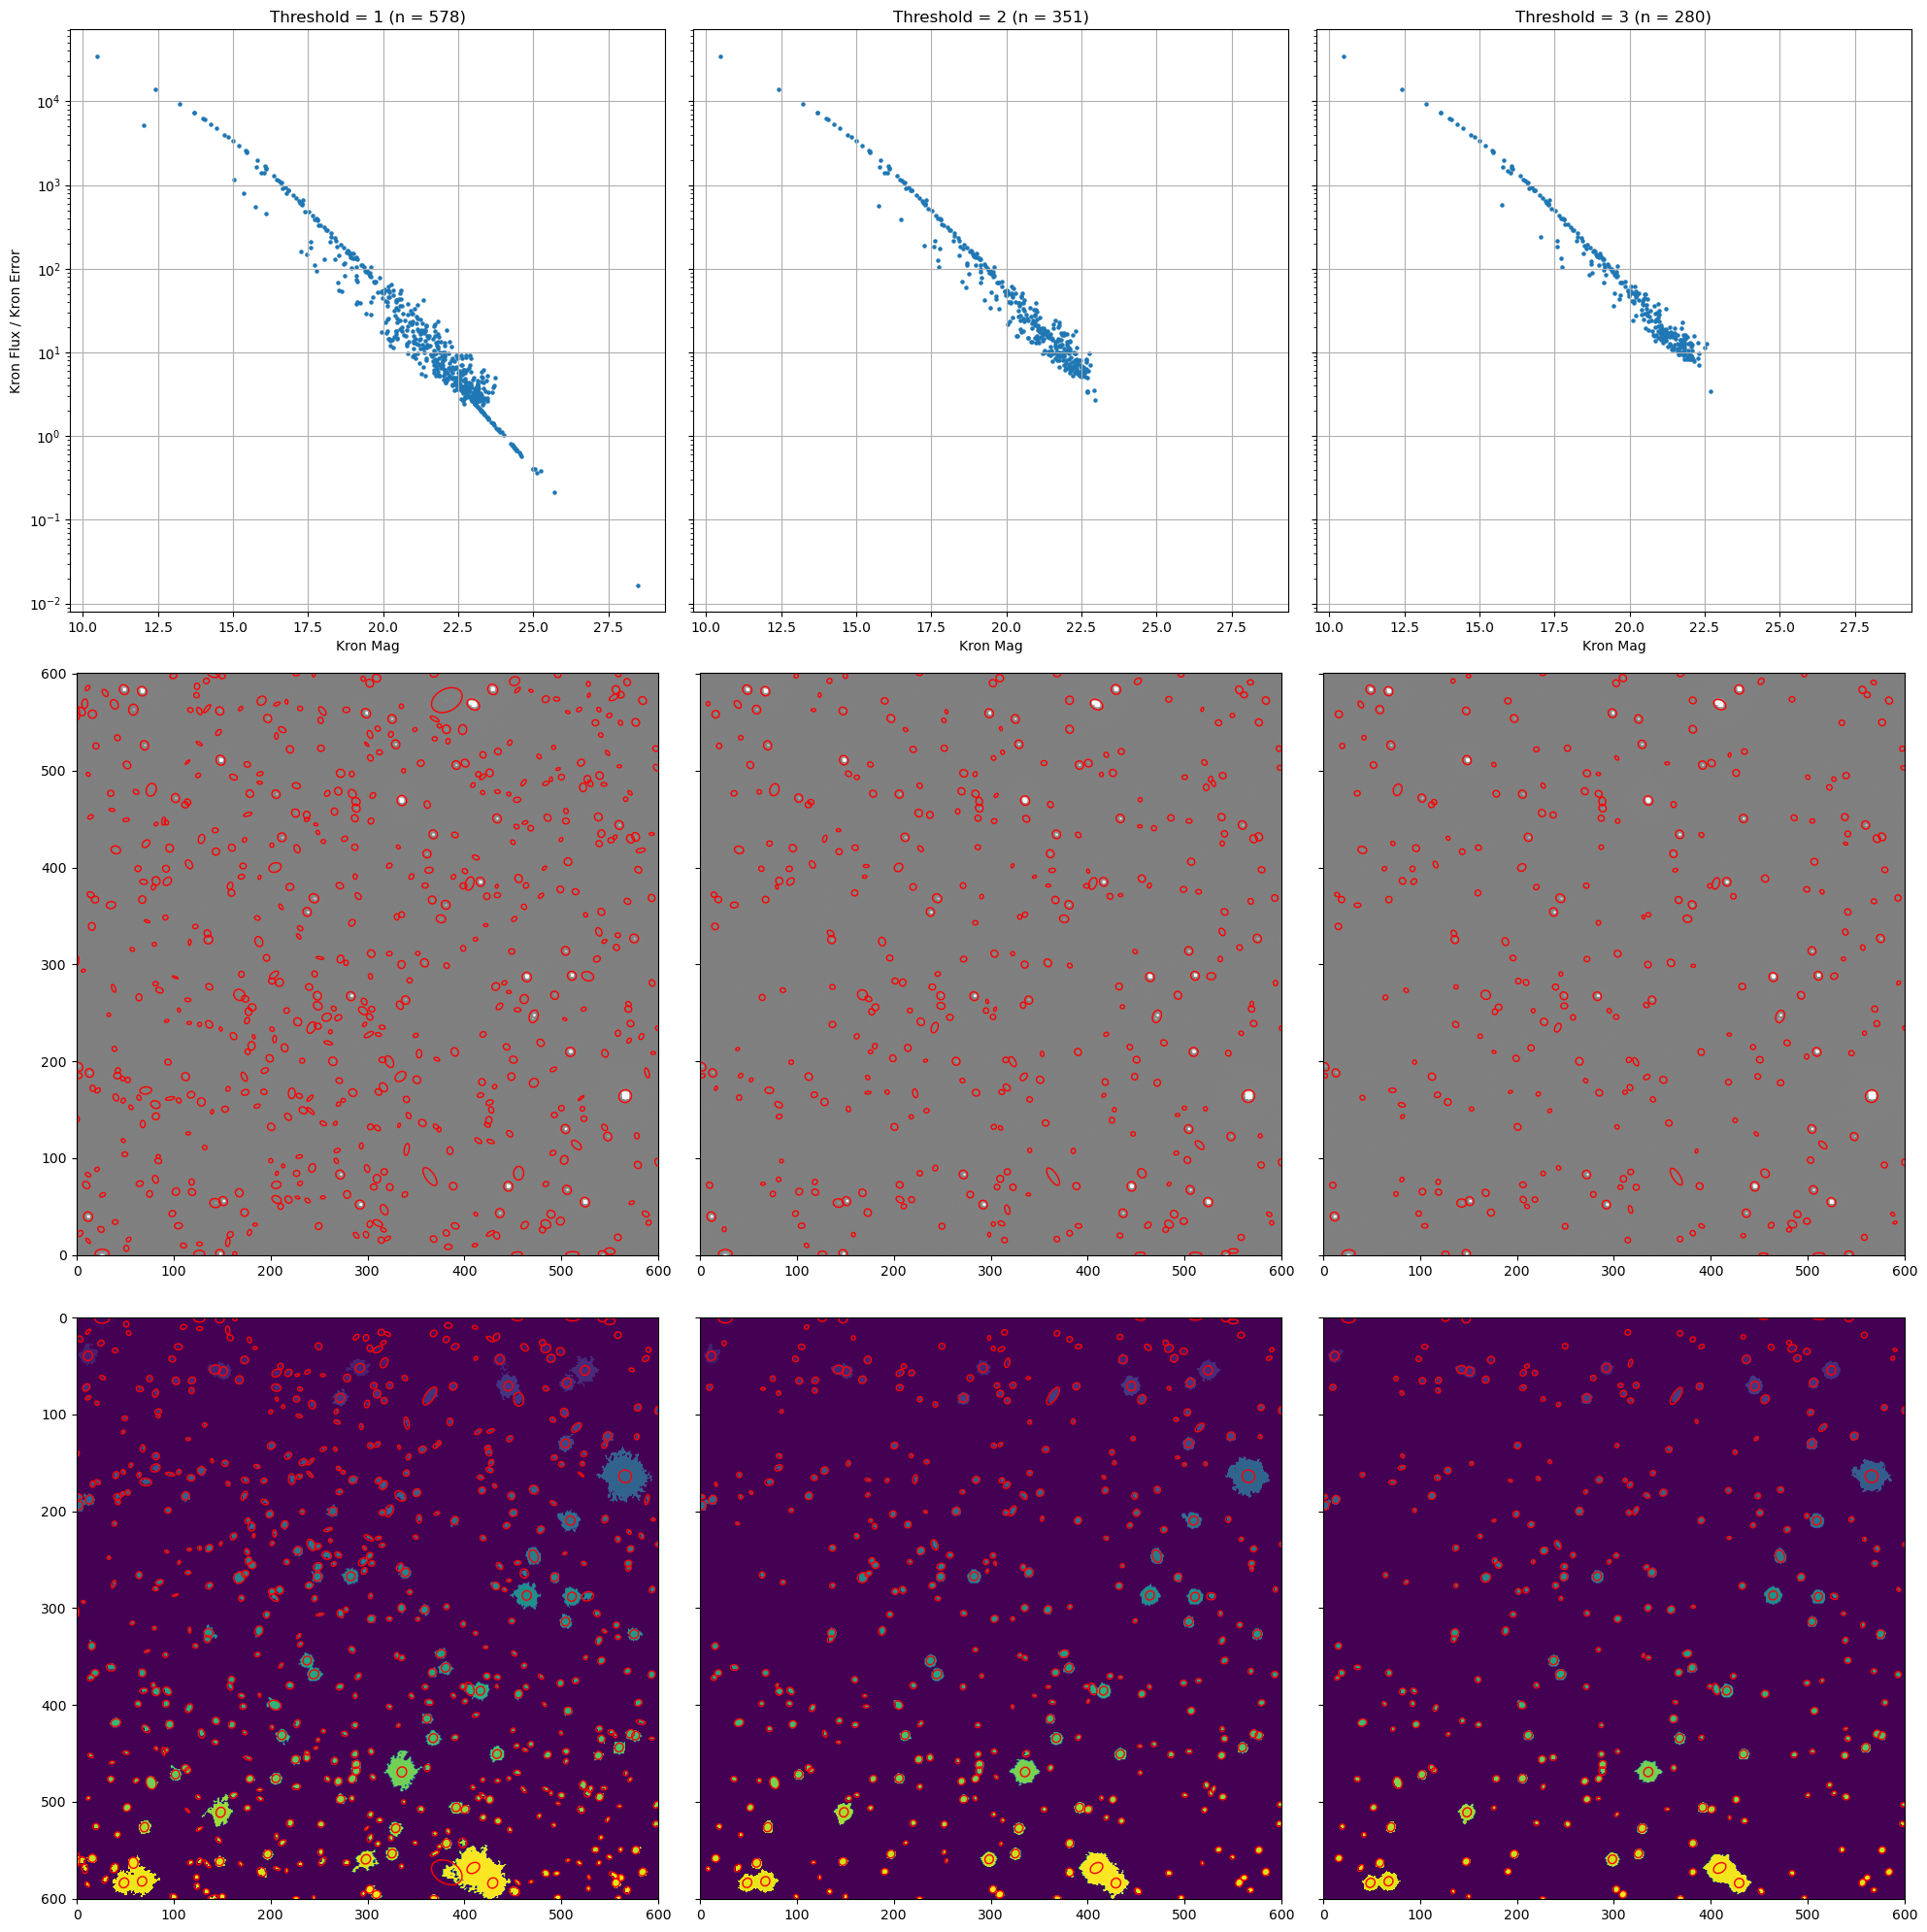

In [146]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex='row', sharey='row')

hdul = fits.open('Data/random_sky_images/test5.fits')
image_data = hdul[0].data
image_data = image_data.byteswap().newbyteorder()
# image_data = replace_nan_border(image_data)  # TODO: FIX THE NAN BORDER THING
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)
bkg_image = bkg.back()
data_sub = image_data - bkg_image
data_sub[np.isnan(data_sub)] = np.nanmax(data_sub)
cmap = plt.get_cmap('plasma')

# Params
gain = 5.8*hdul[0].header['NFRAMES']  # gain from ZTF paper https://iopscience.iop.org/article/10.1088/1538-3873/aaecbe/pdf
r_fwhm = hdul[0].header['MEDFWHM']
zero_pt_mag = hdul[0].header['MAGZP']
deblend_cont = 0.00075
minarea=5
deblend_nthresh = 32

for top_ax, middle_ax, bottom_ax, thresh in zip(axes[0].flatten(), axes[1].flatten(), axes[2].flatten(), [1, 2, 3]):
    im = middle_ax.imshow(data_sub, interpolation='nearest', cmap='gray',
                vmin=m-3*s, vmax=m+3*s, origin='lower')
    # Extract objects
    objects, seg_map = sep.extract(data_sub,
                                   thresh=thresh,
                                   err=bkg.globalrms,
                                   deblend_cont=deblend_cont,
                                   minarea=minarea,
                                   segmentation_map=True,
                                   gain=gain,
                                   deblend_nthresh=deblend_nthresh)

    # Do photometry
    # objects = objects[np.logical_or(objects['theta'] > np.pi / 2, objects['theta'] < -1 * np.pi / 2)]
    objects['theta'][objects['theta'] > np.pi / 2] -= np.pi
    objects['theta'][objects['theta'] < -1 * np.pi / 2] += np.pi / 2
    kronrad, krflag = sep.kron_radius(data_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], 6.0)

    # Kron flux for sources with a radius smaller than 1.0
    r_min = 0.5  # minimum diameter = 1
    use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min
    flux, fluxerr, flag = sep.sum_ellipse(data_sub,
                                          objects['x'][~use_circle],
                                          objects['y'][~use_circle],
                                          objects['a'][~use_circle],
                                          objects['b'][~use_circle],
                                          objects['theta'][~use_circle],
                                          2.5*kronrad[~use_circle],
                                          err=bkg.globalrms,
                                          gain=gain)
    cflux, cfluxerr, cflag = sep.sum_circle(data_sub,
                                            objects['x'][use_circle],
                                            objects['y'][use_circle],
                                            2.5*r_fwhm,
                                            subpix=1,
                                            err=bkg.globalrms,
                                            gain=gain)
    flux = np.hstack((flux, cflux))
    fluxerr = np.hstack((fluxerr, cfluxerr))
    mag = img_flux_to_ab_mag(flux, zero_pt_mag)

    # Update the objects array to include new fields
    photometry_array = np.array([(m, f, ferr) for m, f, ferr in zip(mag, flux, fluxerr)], dtype=[('kronmag', float), ('kronflux', float), ('kronfluxerr', float)])
    new_dtype = np.dtype(objects.dtype.descr + photometry_array.dtype.descr)
    new_objects = np.zeros(objects.shape, dtype=new_dtype)
    for name in objects.dtype.names:
        new_objects[name] = objects[name]
    for name in photometry_array.dtype.names:
        new_objects[name] = photometry_array[name]
    objects = new_objects

    # Plot the Kron flux vs Kron flux error
    top_ax.set_xlabel('Kron Mag')
    top_ax.set_title(f'Threshold = {thresh} (n = {len(objects)})')
    top_ax.scatter(objects['kronmag'], objects['kronflux'] / objects['kronfluxerr'], s=5)
    top_ax.set_yscale('log')
    top_ax.grid(':', zorder=-10)

    # Plot the image with the sources circles
    m, s = np.nanmedian(data_sub), np.nanstd(data_sub)
    im = middle_ax.imshow(data_sub, interpolation='nearest', cmap='gray',
                   vmin=m-3*s, vmax=m+3*s, origin='lower')
    for j in range(len(objects)):
        e = Ellipse(xy=(objects['x'][j], objects['y'][j]),
                    width=6*objects['a'][j],
                    height=6*objects['b'][j],
                    angle=objects['theta'][j] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        middle_ax.add_artist(e)

    # Plot the segmentation map
    bottom_ax.imshow(seg_map)
    for j in range(len(objects)):
        e = Ellipse(xy=(objects['x'][j], objects['y'][j]),
                    width=6*objects['a'][j],
                    height=6*objects['b'][j],
                    angle=objects['theta'][j] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        bottom_ax.add_artist(e)
    print(f'Data/random_sky_images/coordinates_thresh{thresh}.txt')
    with open(f'Data/random_sky_images/coordinates_thresh{thresh}.txt', 'w') as f:
        for j in range(len(objects)):
            f.write(f"{objects['x'][j] + 1} {objects['y'][j] + 1}\n")

axes[0][0].set_ylabel('Kron Flux / Kron Error')
plt.tight_layout()
plt.show()

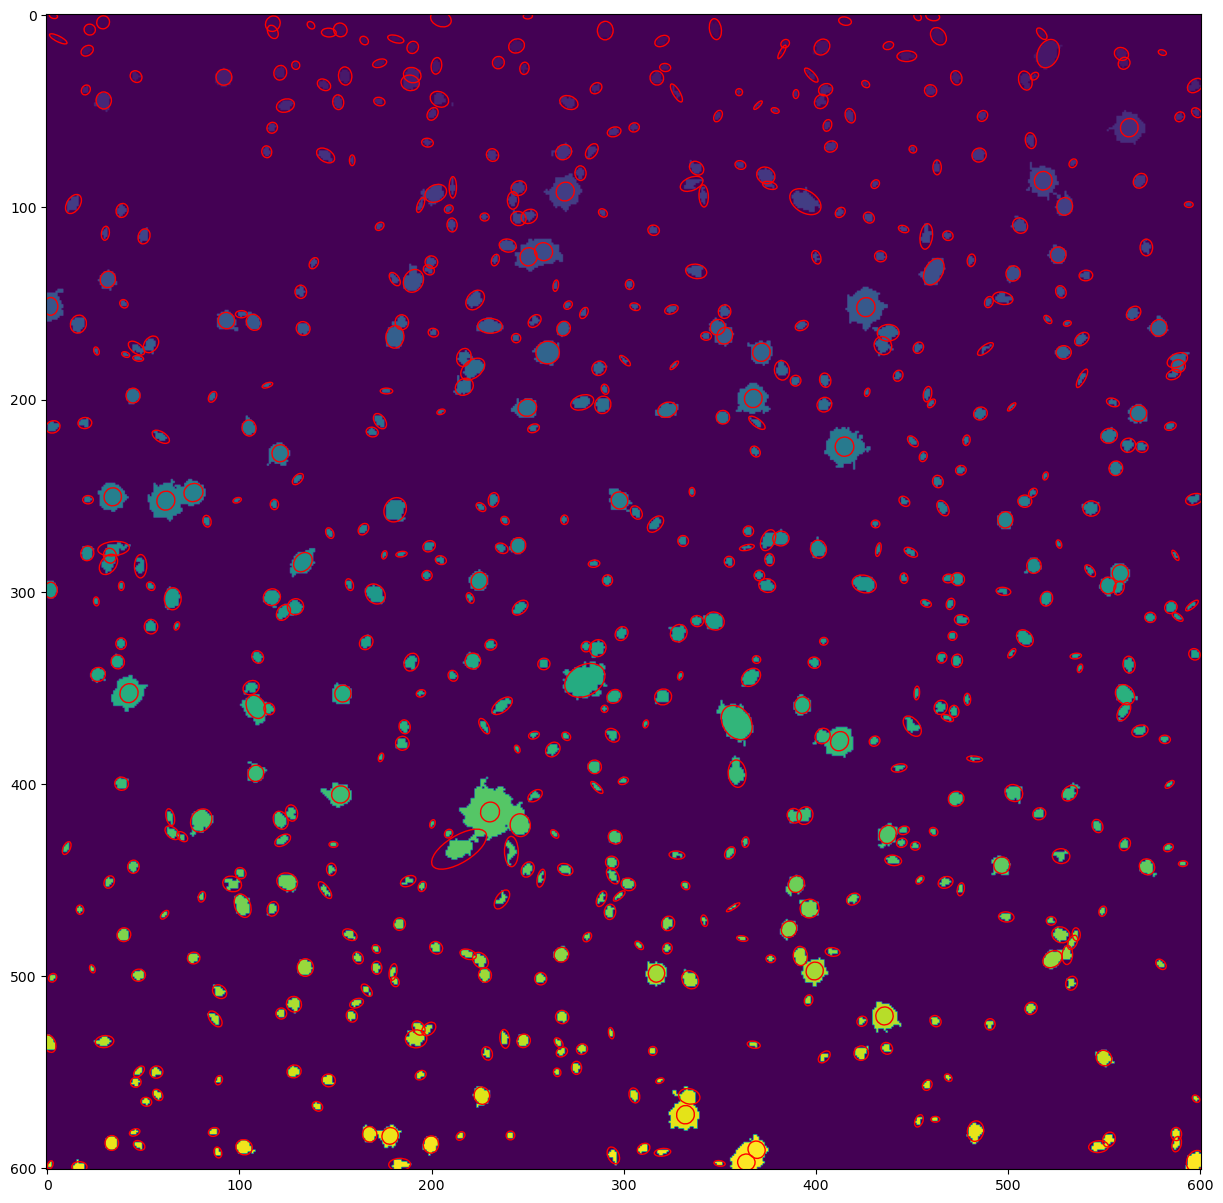

In [130]:
import importlib
import Source_Extractor
importlib.reload(Source_Extractor)
from Source_Extractor import Source_Extractor

sextractor = Source_Extractor('Data/random_sky_images/test4.fits')
sextractor.plot_segmap()

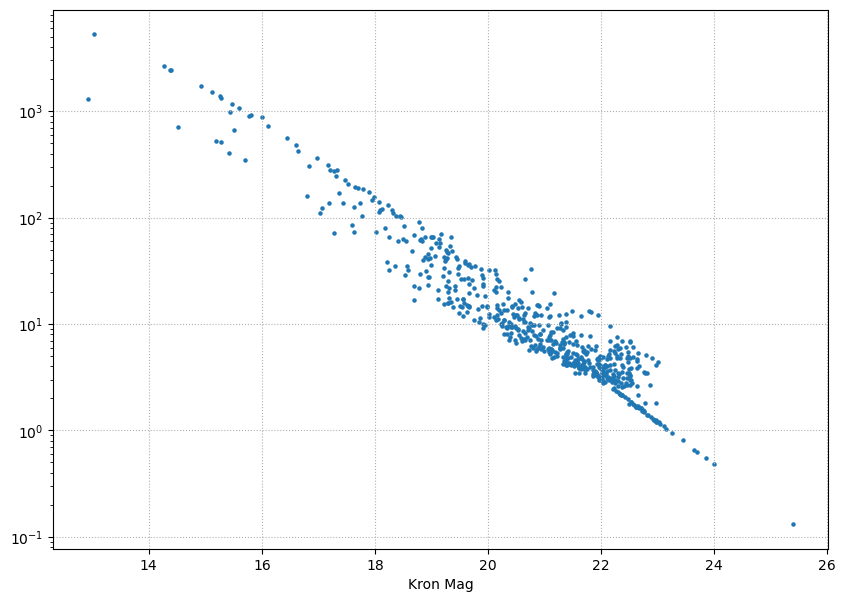

In [10]:
import matplotlib.pyplot as plt

source_photo = sextractor.get_kron_mags()

# Plot the Kron flux vs Kron flux error
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel('Kron Mag')
ax.scatter(source_photo['kronmag'], source_photo['kronflux'] / source_photo['kronfluxerr'], s=5)
ax.set_yscale('log')
ax.grid(ls=':', zorder=-10)

In [11]:
sources = sextractor.get_ra_dec()
sources

array([[158.78363445,   6.08641515],
       [158.85259895,   6.08638864],
       [158.90924528,   6.08628794],
       ...,
       [158.88583959,   5.9225329 ],
       [158.88434795,   5.92072255],
       [158.94964559,   5.92090387]])

In [4]:
import importlib
import Source_Extractor
importlib.reload(Source_Extractor)
from Source_Extractor import Source_Extractor

sextractor = Source_Extractor('Data/random_sky_images/test4.fits')
# ztf_unmatched, pstar_unmatched, unassociated_inds = sextractor.get_pstar_catalog_difference()
# ztf_unmatched, pstar_unmatched

In [5]:
sextractor.get_coord_range()

((158.7827455489754, 158.95063128272503),
 (5.919562391156848, 6.086505430490379))

In [147]:
from astropy.coordinates import SkyCoord
with open('pstar_test.txt', 'w') as f:
    for s in zip(sextractor.pstar_sources['raMean'], sextractor.pstar_sources['decMean']):
        s = sextractor.wcs.world_to_pixel(SkyCoord(s[0], s[1], unit='deg'))
        f.write(f"{s[0]} {s[1]}\n")

with open('ztf_test.txt', 'w') as f:
    for s in sextractor.get_sources_ra_dec():
        s = sextractor.wcs.world_to_pixel(SkyCoord(s[0], s[1], unit='deg'))
        f.write(f"{s[0]} {s[1]}\n")

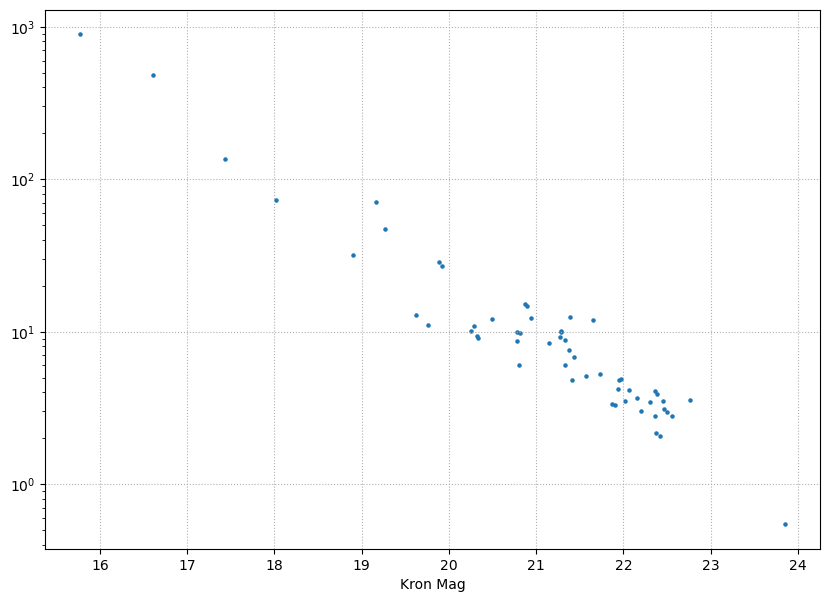

In [92]:
import matplotlib.pyplot as plt

source_photo = sextractor.get_kron_mags()

# Plot the Kron flux vs Kron flux error
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel('Kron Mag')
ax.scatter(source_photo['kronmag'][unassociated_inds], source_photo['kronflux'][unassociated_inds] / source_photo['kronfluxerr'][unassociated_inds], s=5)
ax.set_yscale('log')
ax.grid(ls=':', zorder=-10)

In [88]:
sextractor.sources.shape

(612,)

In [76]:
len(ztf_unmatched), len(pstar_unmatched)

(57, 57)

In [148]:
ztf_pix = sextractor.wcs.all_world2pix(np.vstack((ztf_unmatched.ra.deg, ztf_unmatched.dec.deg)).T, 0)
pstar_pix = sextractor.wcs.all_world2pix(np.vstack((pstar_unmatched.ra.deg, pstar_unmatched.dec.deg)).T, 0)

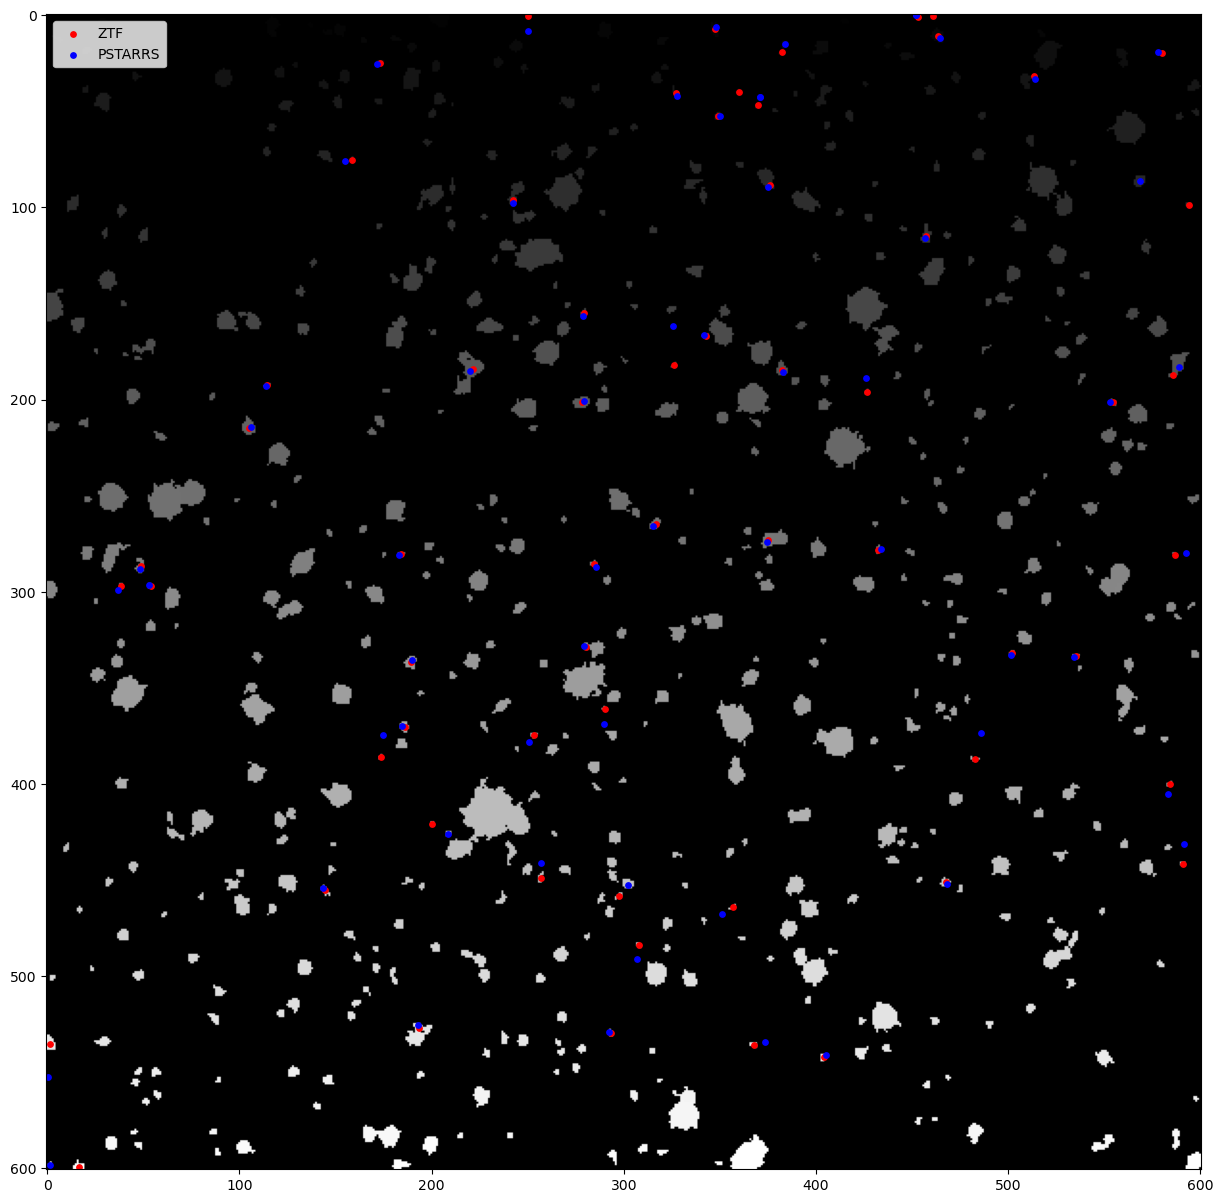

In [150]:
sextractor.plot_segmap(show_sources=False, cmap='gray')

plt.scatter(ztf_pix[:, 0], ztf_pix[:, 1], s=15, c='red', label='ZTF')
plt.scatter(pstar_pix[:, 0], pstar_pix[:, 1], s=15, c='blue', label='PSTARRS')
plt.legend()
plt.show()

In [21]:
import numpy as np
np.sum(in_pstar) / len(in_pstar)

1.0

In [27]:
sextractor.wcs.pixel_to_world(0,0), sextractor.wcs.pixel_to_world(0,sextractor.image_data.shape[1]), sextractor.wcs.pixel_to_world(sextractor.image_data.shape[0],0), sextractor.wcs.pixel_to_world(sextractor.image_data.shape[0],sextractor.image_data.shape[1])

(<SkyCoord (ICRS): (ra, dec) in deg
     (158.78274555, 6.08650543)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (158.78277017, 5.91956239)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (158.95063128, 6.08650259)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (158.95060485, 5.91956209)>)

In [160]:
sextractor.header

SIMPLE  =                    T / This is a FITS file                            
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  601 / NUMBER OF ELEMENTS ALONG THIS AXIS             
NAXIS2  =                  601 / NUMBER OF ELEMENTS ALONG THIS AXIS             
BUNIT   = 'DN'                 / units of pixel values                          
EXTEND  =                    T / This file may contain FITS extensions          
EQUINOX =   2.000000000000E+03 / Mean equinox                                   
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CRVAL1  =   1.585656199000E+02 / World coordinate on this axis                  
CRPIX1  = -7.765000000000000E+02 / Reference pixel on this axis                 
CD1_1   =   2.777777372621E-

In [24]:
from astroquery.mast import Catalogs

# Define the RA and DEC range
ra_min = 150.0  # Minimum Right Ascension in degrees
ra_max = 151.0  # Maximum Right Ascension in degrees
dec_min = 2.0   # Minimum Declination in degrees
dec_max = 3.0   # Maximum Declination in degrees

# Query Pan-STARRS DR2 using the specified RA and DEC range
# 'panstarrs_dr2' is the catalog name for Pan-STARRS DR2
# Limit the search to the desired RA and DEC range
query = f"ra > {ra_min} and ra < {ra_max} and dec > {dec_min} and dec < {dec_max}"

# Execute the query
sources = Catalogs.query_criteria(catalog='PanSTARRS', criteria=query)

# Display the results
print(sources)

       objName        objAltName1 objAltName2 ... yMeanApMagNpt yFlags
--------------------- ----------- ----------- ... ------------- ------
PSO J214.8819-34.3010        -999        -999 ...             0      0
PSO J214.8768-34.2992        -999        -999 ...             0      4
PSO J214.8769-34.2894        -999        -999 ...             0      0
PSO J214.8852-34.2872        -999        -999 ...             0      4
PSO J214.8800-34.2812        -999        -999 ...             0      0
PSO J214.8786-34.2642        -999        -999 ...             0      0
PSO J214.9196-34.2610        -999        -999 ...             0      0
PSO J214.8765-34.2919        -999        -999 ...             0      0
PSO J214.8758-34.2843        -999        -999 ...             0      0
PSO J214.8902-34.2918        -999        -999 ...             0      0
                  ...         ...         ... ...           ...    ...
PSO J003.9713-29.9840        -999        -999 ...             0      0
PSO J0

In [93]:
with open('test.txt', 'w') as f:
    for s in ztf_pix:
        f.write(f"{s[0]} {s[1]}\n")

In [95]:
with open('test_pstar.txt', 'w') as f:
    for s in pstar_pix:
        f.write(f"{s[0]} {s[1]}\n")

In [128]:
import requests
import os

# Function to download an image from the ZTF API based on RA and Dec
def download_ztf_image_by_coordinates(ra, dec, radius_arcmin, save_path):
    """
    Downloads an image from the ZTF API using RA and Dec coordinates and saves it to a specified path.

    Args:
        ra (float): The Right Ascension (in degrees).
        dec (float): The Declination (in degrees).
        radius_arcmin (float): The search radius (in arcminutes).
        save_path (str): The directory path where the image will be saved.
    """
    # ZTF API URL for image search based on coordinates (RA, Dec, radius)
    ztf_api_url = f"https://ztfweb.ipac.caltech.edu/cgi-bin/getimage.cgi?ra={ra}&dec={dec}&size={radius_arcmin}"

    try:
        # Send a GET request to the ZTF API to download the image
        response = requests.get(ztf_api_url, stream=True)

        # Check if the request was successful
        if response.status_code == 200:
            # Make sure the save directory exists
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            
            # Construct the image file path
            image_file = os.path.join(save_path, f"ztf_image_{ra}_{dec}.fits")

            # Write the image content to a file
            with open(image_file, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)

            print(f"Image for RA: {ra}, Dec: {dec} downloaded successfully and saved to {image_file}.")
        else:
            print(f"Failed to download image. HTTP status code: {response.status_code}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
ra = 180.0  # Replace with the Right Ascension in degrees
dec = 30.0  # Replace with the Declination in degrees
radius_arcmin = 10  # Search radius in arcminutes
save_directory = './ztf_images'  # Directory where the image will be saved

download_ztf_image_by_coordinates(ra, dec, radius_arcmin, save_directory)

Failed to download image. HTTP status code: 401


In [21]:
from ztfquery import query
zquery = query.ZTFQuery()
# test = zquery.load_metadata(kind="ref", radec=[276.107960, +44.130398])
# zquery.load_metadata(kind="ref", radec=[276.107960, +44.130398])
# zquery.load_metadata(kind="ref",radec=[276.107960, +44.130398], size=0.0001)

In [24]:
test = zquery.load_metadata(kind="ref", radec=[276.107960, +44.130398])
test

In [19]:
zquery.get_local_data("sciimg.fits")

reference_path: {'paddedfield': '000726', 'filtercode': 'zg', 'paddedccdid': '15', 'qid': '2', 'fieldprefix': '000', 'suffix': 'sciimg.fits', 'source': 'local', 'verbose': True}
reference_path: {'paddedfield': '000726', 'filtercode': 'zi', 'paddedccdid': '15', 'qid': '2', 'fieldprefix': '000', 'suffix': 'sciimg.fits', 'source': 'local', 'verbose': True}
reference_path: {'paddedfield': '000726', 'filtercode': 'zr', 'paddedccdid': '15', 'qid': '2', 'fieldprefix': '000', 'suffix': 'sciimg.fits', 'source': 'local', 'verbose': True}
reference_path: {'paddedfield': '000764', 'filtercode': 'zr', 'paddedccdid': '01', 'qid': '3', 'fieldprefix': '000', 'suffix': 'sciimg.fits', 'source': 'local', 'verbose': True}
reference_path: {'paddedfield': '000764', 'filtercode': 'zi', 'paddedccdid': '01', 'qid': '3', 'fieldprefix': '000', 'suffix': 'sciimg.fits', 'source': 'local', 'verbose': True}
reference_path: {'paddedfield': '000764', 'filtercode': 'zg', 'paddedccdid': '01', 'qid': '3', 'fieldprefix': 

[]

In [25]:
from ztfquery import io
io.download_from_filename("sciimg.fits")

FileNotFoundError: [Errno 2] No such file or directory: ''

In [2]:
import importlib
import Tile
importlib.reload(Tile)

ra, dec = 158.49, 5.71

test = Tile.Tile(ra, dec)

KeyboardInterrupt: 

In [2]:
tab = test.data

NameError: name 'test' is not defined

In [7]:
np.sum(tab['Catalog'] == 'PSTARR'), np.sum(tab['Catalog'] == 'ZTF'), np.sum(tab['Catalog'] == 'Both')

(1222, 64, 548)

In [6]:
tab['association_separation_arcsec']

0.2603774962026632
0.6414745052426015
0.41684093683255885
0.435145493393885
0.7158806607327725
0.32563115812288806
0.6201637201662316
0.11425694517066633
0.5329289419944947
0.10550381214120082
0.28017484990305286


In [11]:
tab[np.isnan(tab['association_separation_arcsec'])]

ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_flag,ZTF_gKronMag,ZTF_gKronMagErr,ra,dec,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_rKronMag,PSTARR_iKronMag,PSTARR_zKronMag,PSTARR_yKronMag,PSTARR_gKronMagErr,PSTARR_rKronMagErr,PSTARR_iKronMagErr,PSTARR_zKronMagErr,PSTARR_yKronMagErr,PSTARR_gPSFMag,PSTARR_rPSFMag,PSTARR_iPSFMag,PSTARR_zPSFMag,PSTARR_yPSFMag,PSTARR_gPSFMagErr,PSTARR_rPSFMagErr,PSTARR_iPSFMagErr,PSTARR_zPSFMagErr,PSTARR_yPSFMagErr,PSTARR_ra,PSTARR_dec,association_separation_arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0912655591964722,6.0,5.0,249.0,251.0,0.0,1.0,250.06012490889762,0.438889233610438,0.6369643347610439,0.2462654742312804,-0.029359925407613674,0.07440094069632572,0.028166660776073396,-0.00041916676922611825,0.799473762512207,0.49403589963912964,-0.07458893209695816,1.5786216259002686,4.083096504211426,0.37640851736068726,8.038237571716309,10.4632568359375,1.678542137145996,3.4904632568359375,251.0,0.0,250.0,0.0,2.0,22.46377615858634,0.35062631853877324,nan,nan,158.8525989542429,6.0863886356260455,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0912655591964722,6.0,5.0,452.0,454.0,0.0,2.0,452.8440266002208,0.7926125849967343,0.42433155006322776,0.4432489570560918,0.1155941870494338,0.04395383639972639,0.044104525414542586,0.012880427236178939,0.7414652705192566,0.5637461543083191,0.8262206315994263,2.5368738174438477,2.428602695465088,-1.3231745958328247,8.779610633850098,12.318023681640625,1.8702621459960938,3.3669586181640625,453.0,1.0,453.0,0.0,2.0,22.36419484945699,0.26446820391375825,nan,nan,158.90924528239037,6.086287938330071,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0912655591964722,15.0,12.0,458.0,463.0,0.0,3.0,460.72593246144845,0.6131086850442538,1.4446634144820552,0.5762162632185275,0.17844650999720524,0.021397640400584558,0.009661193978638774,0.0036967824853389713,1.216511607170105,0.735512912273407,0.1949574202299118,0.7197346687316895,1.8044862747192383,-0.4457845091819763,42.33998107910156,56.75224304199219,6.4575347900390625,14.800033569335938,461.0,0.0,461.0,0.0,2.0,21.278624441078623,0.11738664714368804,nan,nan,158.91144703167458,6.086337585235088,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0912655591964722,28.0,23.0,346.0,350.0,4.0,11.0,347.63195760364306,7.236610459843048,1.1110594902910513,3.300882820938913,0.35511017507619425,0.013836504155381705,0.041095645148163516,0.004978094762113572,1.8322197198867798,1.0270895957946777,1.4139844179153442,0.9320909976959229,0.31373685598373413,-0.20054937899112701,57.45625686645508,65.9100341796875,3.7939844131469727,5.1703948974609375,348.0,6.0,348.0,6.0,0.0,19.583355057817073,0.041409197756086216,nan,nan,158.87985501826708,6.08449997855454,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0912655591964722,37.0,32.0,460.0,466.0,7.0,14.0,463.69162796120094,10.962247489992821,1.904711789606198,2.2887077464524452,0.5549105134550611,0.006594537330732603,0.00781221928130161,0.0016154552977303786,1.6382603645324707,1.2286262512207031,0.9519507884979248,0.5649173259735107,0.4701363444328308,-0.2739349901676178,138.88497924804688,147.02662658691406,9.341973304748535,12.823928833007812,4

In [8]:
from Catalogs import ZTF_Catalog

In [2]:
ZTF_Catalog(158.78274555, 6.08650543)
# ZTF_Catalog(0.0, 0.1)

Index(['infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode',
       'rfid', 'nframes', 'maglimit', 'startobsdate', 'endobsdate', 'crpix1',
       'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra',
       'dec', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4',
       'ipac_pub_date', 'ipac_gid', 'meta_id'],
      dtype='object')
   infobits  field  ccdid  qid  rcid  fid filtercode           rfid  nframes  \
0         0    469     14    4    55    1         zg  1000469130155      100   
3         0    469     14    3    54    1         zg  1000469130154      100   
4         0    469     10    1    36    1         zg  1000469130136      100   
7         0    469     10    2    37    1         zg  1000469130137      100   
6         0   1516      3    2     9    1         zg  1001516130109       27   
5         0   1516      7    3    26    1         zg  1001516130126       23   
2         0   1516      8    4    31    1         zg  1001516130131   

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Index(['infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode',
       'rfid', 'nframes', 'maglimit', 'startobsdate', 'endobsdate', 'crpix1',
       'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra',
       'dec', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4',
       'ipac_pub_date', 'ipac_gid', 'meta_id'],
      dtype='object')
   infobits  field  ccdid  qid  rcid  fid filtercode           rfid  nframes  \
2         0    469     10    1    36    2         zr  1000469130236      100   
4         0    469     14    3    54    2         zr  1000469130254      100   
6         0    469     10    2    37    2         zr  1000469130237      100   
7         0    469     14    4    55    2         zr  1000469130255      100   
1         0   1516      3    2     9    2         zr  1001516130209       32   
5         0   1516      8    4    31    2         zr  1001516130231       30   
0         0   1516      7    3    26    2         zr  1001516130226   

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Index(['infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode',
       'rfid', 'nframes', 'maglimit', 'startobsdate', 'endobsdate', 'crpix1',
       'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra',
       'dec', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4',
       'ipac_pub_date', 'ipac_gid', 'meta_id'],
      dtype='object')
   infobits  field  ccdid  qid  rcid  fid filtercode           rfid  nframes  \
2         0    469     10    2    37    3         zi  1000469130337       49   
3         0    469     10    3    38    3         zi  1000469130338       38   
0         0    469     14    4    55    3         zi  1000469130355       34   
1         0    469     14    3    54    3         zi  1000469130354       30   

    maglimit  ...      dec1         ra2      dec2         ra3      dec3  \
2  21.999201  ...  6.402795  159.012590  6.403276  159.012350  5.514431   
3  22.041000  ...  5.536266  159.013896  5.536873  159.013888  4.648029   
0  2

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# SN Examples

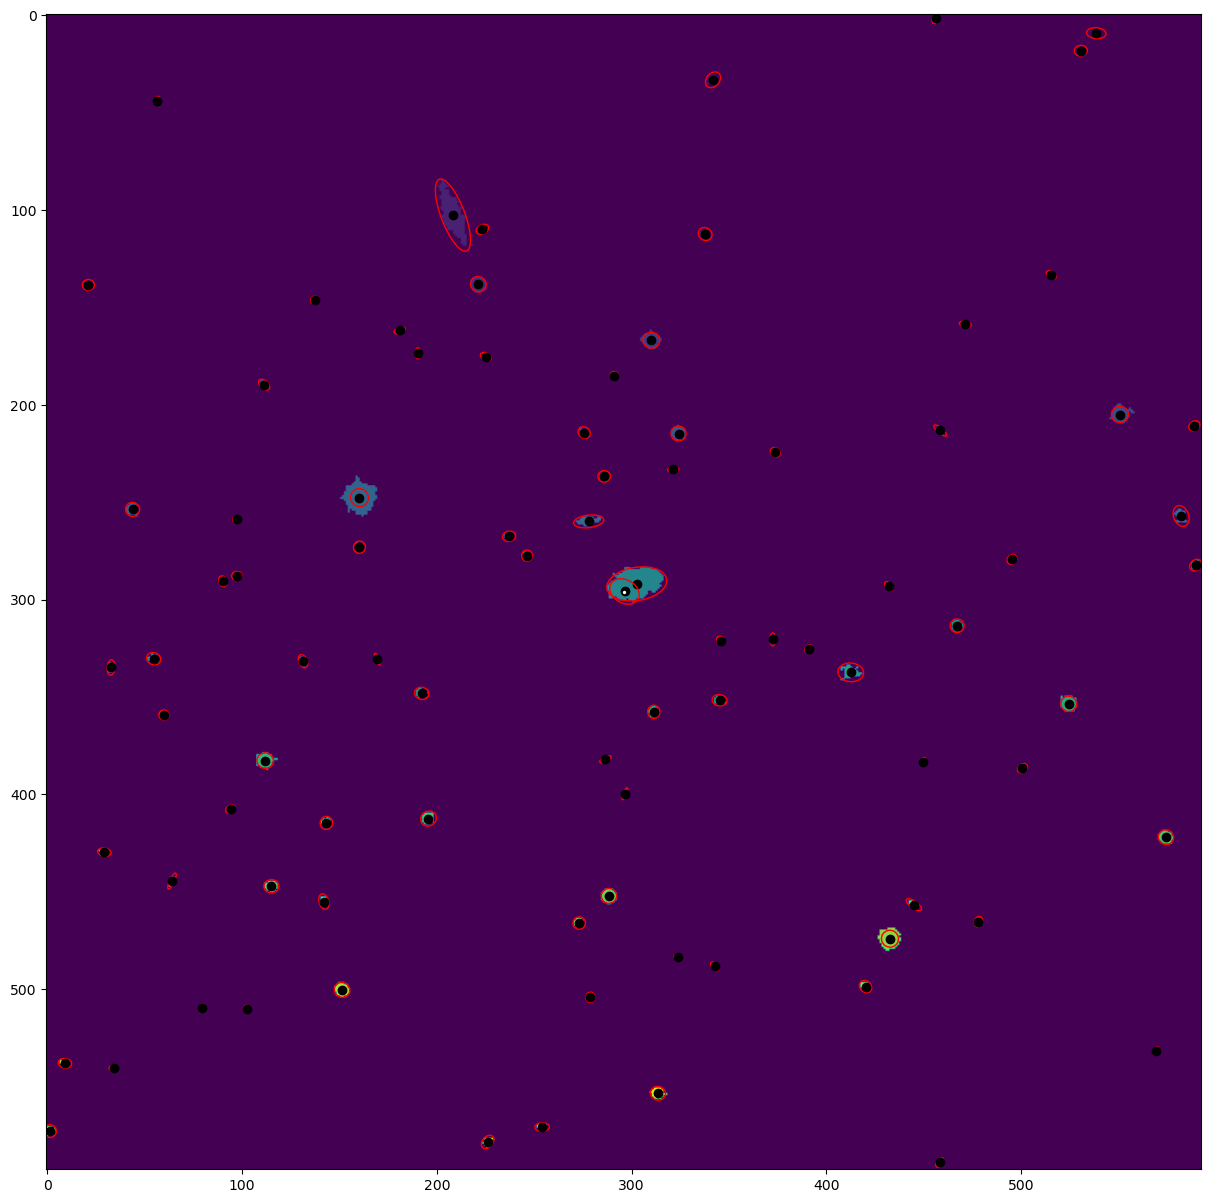

In [7]:
from Source_Extractor import Source_Extractor
sextractor = Source_Extractor('/Users/adamboesky/Research/long_transients/Data/sne_examples/sn3.fits')
from astropy.coordinates import SkyCoord
coords = SkyCoord(ra=[50.09275], dec=[-5.606311], unit='deg')
coord_pix = sextractor.wcs.world_to_pixel(coords)
sextractor.plot_segmap()
import matplotlib.pyplot as plt
plt.scatter(coord_pix[0], coord_pix[1], color='white', s=2)

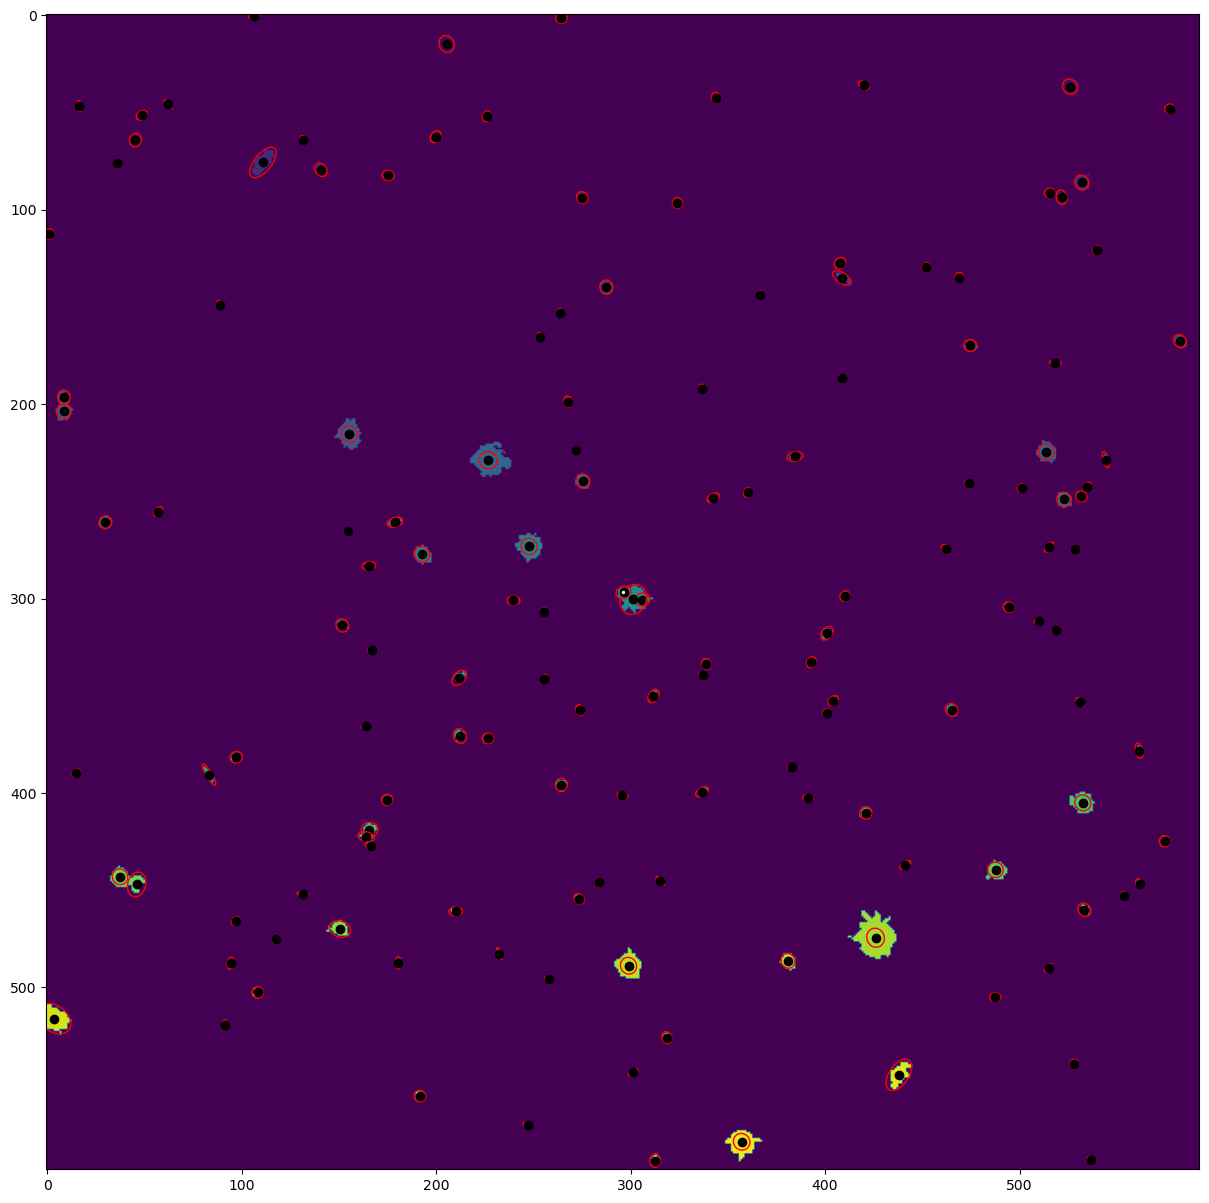

In [8]:
sextractor = Source_Extractor('/Users/adamboesky/Research/long_transients/Data/sne_examples/sn2.fits')
coords = SkyCoord(ra=[31.2370841], dec=[19.580073], unit='deg')
coord_pix = sextractor.wcs.world_to_pixel(coords)
sextractor.plot_segmap()
plt.scatter(coord_pix[0], coord_pix[1], color='white', s=2)

(array([296.89555081]), array([295.96162061]))


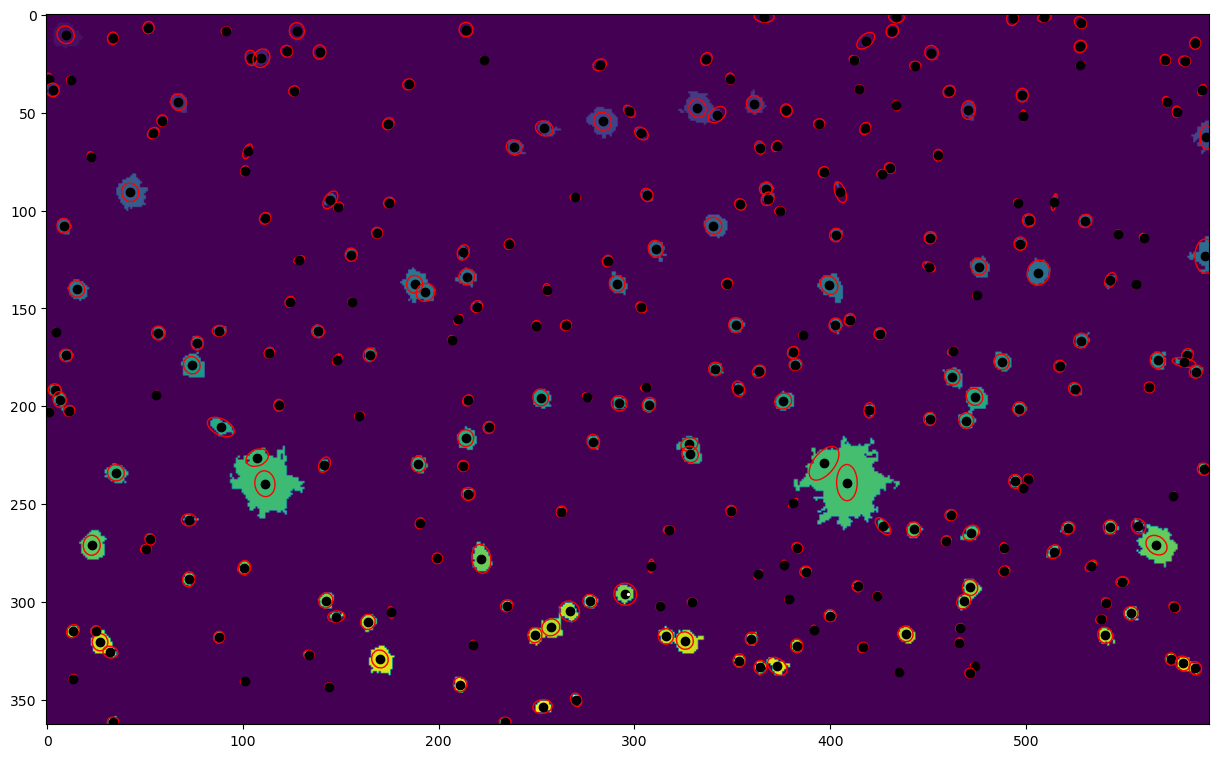

In [10]:
sextractor = Source_Extractor('/Users/adamboesky/Research/long_transients/Data/sne_examples/sn1.fits')
coords = SkyCoord(ra=[8.383990846324686], dec=[43.34932465234231], unit='deg')
coord_pix = sextractor.wcs.world_to_pixel(coords)
sextractor.plot_segmap()
print(coord_pix)
plt.scatter(coord_pix[0], coord_pix[1], color='white', s=2)

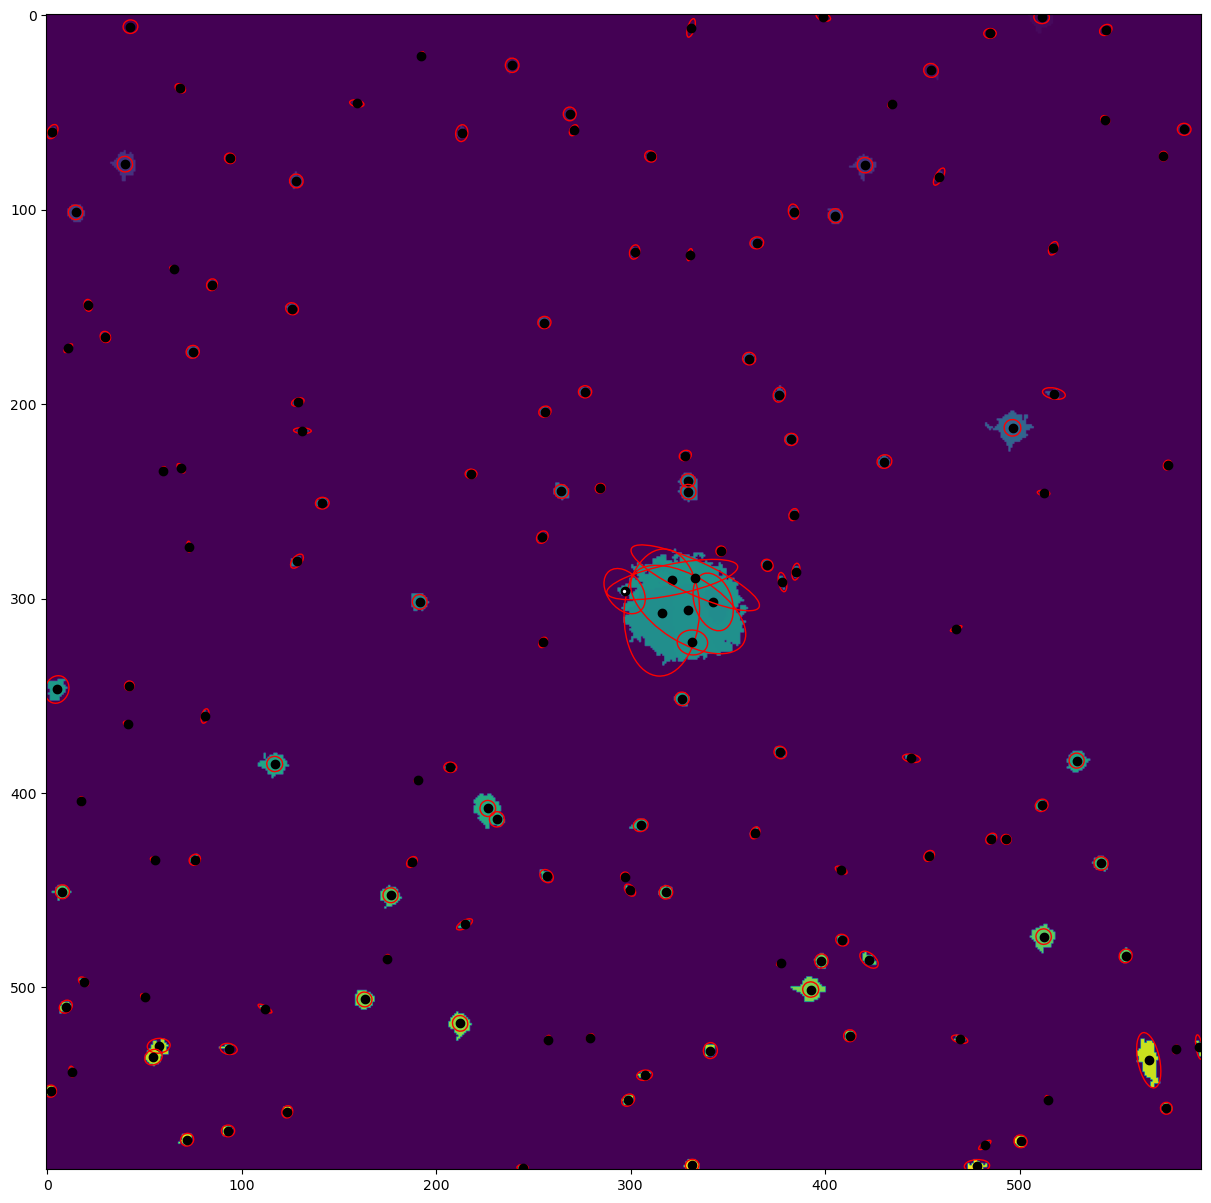

In [12]:
sextractor = Source_Extractor('/Users/adamboesky/Research/long_transients/Data/sne_examples/sn4.fits')
coords = SkyCoord(ra=[3.08935889705], dec=[31.063364657], unit='deg')
coord_pix = sextractor.wcs.world_to_pixel(coords)
sextractor.plot_segmap()
plt.scatter(coord_pix[0], coord_pix[1], color='white', s=2)

# Messing With Tiles

In [3]:
from Source_Extractor import Source_Extractor
sextractor = Source_Extractor('/Users/adamboesky/Research/long_transients/Data/sne_examples/sn1.fits')

In [4]:
sextractor.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  594                                                  
NAXIS2  =                  363                                                  
BUNIT   = 'Data Value'                                                          
ORIGIN  = 'Zwicky Transient Facility' / Data origin                             
OBSERVER= 'ZTF Robotic Observing Software' / Observer                           
ROBOSOFT= '1.13 March 12, 2024' / Robotic software version                      
FITSSOFT= '1.13 March 12, 2024' / FITS software version                         
INSTRUME= 'ZTF/MOSAIC'         / Instrument name                                
DETECTOR= '        '           / Detector controller                            
DETSOFT = '        '        

In [1]:
from Tile import Tile
tile = Tile(3.34, 30.87)

Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmp7bm0k9kw/ztf_000648_zg_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmp7bm0k9kw/ztf_000648_zr_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmp7bm0k9kw/ztf_000648_zi_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
tile.data

Exception: invalid aperture parameters

In [4]:
from scipy.interpolate import NearestNDInterpolator
import numpy as np
notnan_mask = ~np.isnan(tile.ztf_catalog.sextractors['r'].image_data)
notnan_inds = np.where(notnan_mask)
interp = NearestNDInterpolator(np.transpose(notnan_inds), tile.ztf_catalog.sextractors['r'].image_data[notnan_inds])
output = interp(*np.indices(tile.ztf_catalog.sextractors['r'].image_data.shape))
test = np.copy(tile.ztf_catalog.sextractors['r'].image_data)
test[~notnan_mask] = output[~notnan_mask]

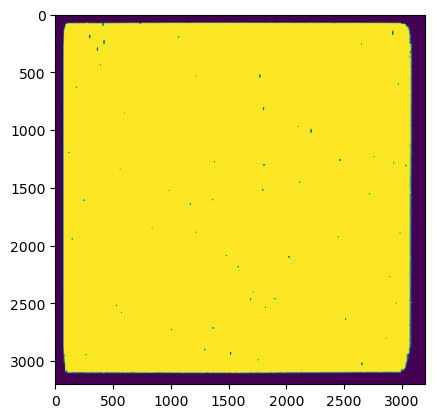

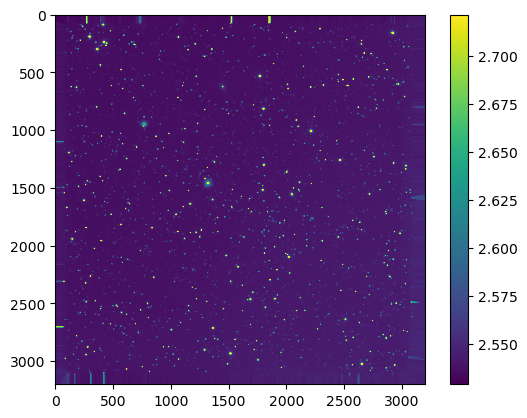

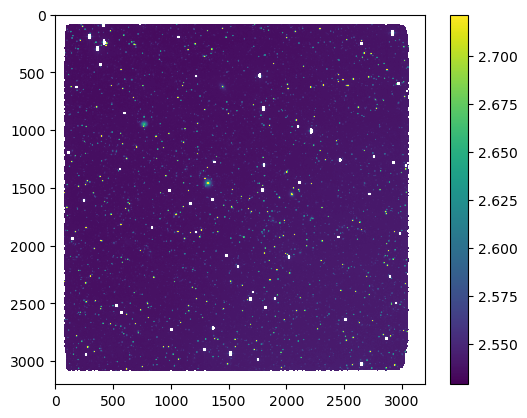

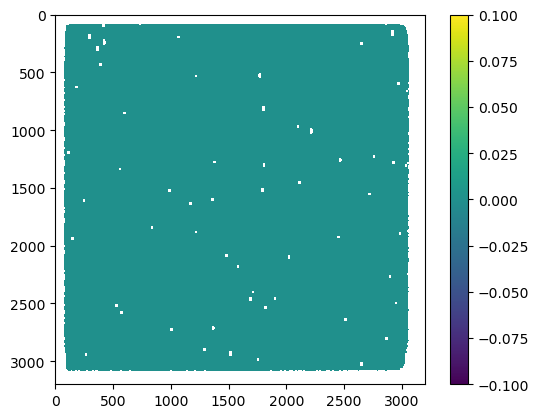

In [21]:
import matplotlib.pyplot as plt

m = np.nanpercentile(np.log10(tile.ztf_catalog.sextractors['r'].image_data.flatten()), 99.75)
# m=np.log10(56673.246 - 1000)
plt.imshow(notnan_mask)
plt.show()
plt.imshow(np.log10(output), vmax=m)
plt.colorbar()
plt.show()
plt.imshow(np.log10(tile.ztf_catalog.sextractors['r'].image_data), vmax=m)
plt.colorbar()
plt.show()
plt.imshow(np.log10(test)-np.log10(tile.ztf_catalog.sextractors['r'].image_data))
plt.colorbar()
plt.show()

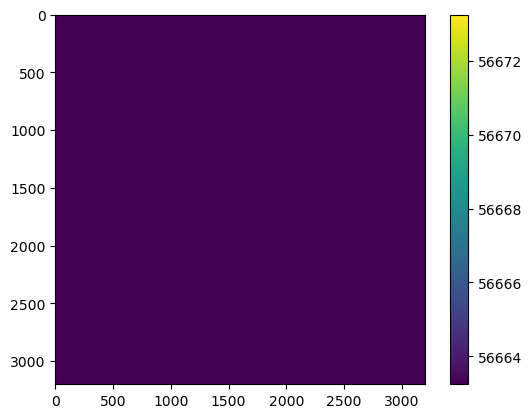

In [6]:
import matplotlib.pyplot as plt
import numpy as np
vmin = np.nanmax(tile.ztf_catalog.sextractors['r'].image_data) - 10
vmax = np.nanmax(tile.ztf_catalog.sextractors['r'].image_data)
plt.imshow(tile.ztf_catalog.sextractors['r'].image_data, vmin=vmin, vmax=vmax)
plt.colorbar()

In [4]:
tile.ztf_catalog.sextractors['g'].plot_segmap()

KeyboardInterrupt: 

In [1]:
from Tile import Tile
tile = Tile(3.34, 30.87)

Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmporpg29o3/ztf_000648_zg_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmporpg29o3/ztf_000648_zr_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmporpg29o3/ztf_000648_zi_c01_q2_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
tile.data

Exception: invalid aperture parameters